# Goal: figure out how to do horizontal bins for $p_{\textrm{features},z=0.3}$

Discussion following telecon on Tom Melvin's thesis corrections (TM,KLM,KW,MG on 29 Jul 2015)

In [1]:
# Set up packages

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import random

In [2]:
# Generate a simulated data set

N = 50
x = np.linspace(0,1,N)
y = (x*x**0.5) + stats.norm(0,0.1).rvs(N)
y[y<0] = 0.
y[y>1] = 1.

In [3]:
'''
Approach: fit data with low-order polynomial, 
then evaluate polynomial near bin points. 

Fit function must pass between (0,0) and (1,1); 
uses method of Lagrange multipliers detailed
here: http://stackoverflow.com/questions/15191088/how-to-do-a-polynomial-fit-with-fixed-points
'''

def polyfit_with_fixed_points(n, x, y, xf, yf) :
    mat = np.empty((n + 1 + len(xf),) * 2)
    vec = np.empty((n + 1 + len(xf),))
    x_n = x**np.arange(2 * n + 1)[:, None]
    yx_n = np.sum(x_n[:n + 1] * y, axis=1)
    x_n = np.sum(x_n, axis=1)
    idx = np.arange(n + 1) + np.arange(n + 1)[:, None]
    mat[:n + 1, :n + 1] = np.take(x_n, idx)
    xf_n = xf**np.arange(n + 1)[:, None]
    mat[:n + 1, n + 1:] = xf_n / 2
    mat[n + 1:, :n + 1] = xf_n.T
    mat[n + 1:, n + 1:] = 0
    vec[:n + 1] = yx_n
    vec[n + 1:] = yf
    params = np.linalg.solve(mat, vec)
    
    return params[:n + 1]

def calculate_hbins(vbins,deg=3):
    
    eps = 1e-3
    xf = (0+eps,1) # offset by small amount so matrix is non-singular
    yf = (0,1)
    p = polyfit_with_fixed_points(deg,x,y,xf,yf)
    poly = np.polynomial.Polynomial(p)
    
    return poly

In [4]:
def plot_hbins(poly):
    fig,ax = plt.subplots()
    ax.scatter(x,y)
    x_new = np.linspace(0,1,1000)
    ax.plot(x_new,poly(x_new),color='k',ls='--')
    astart,vstart = 0.,0.
    for vb in vbins:
        hb = poly(vb)
        aend = 1. if vb==1. else hb
        ax.axhspan(astart,aend,alpha=0.5,color="#%06x" % random.randint(0, 0xFFFFFF))
        ax.text(1.1,np.mean((astart,aend)),'Bin %.1f to %.1f' % (vstart,vb) )
        vstart = vb
        astart = hb
    ax.set_xlim(0,1);
    ax.set_ylim(0,1);
    
    return None

Values of p_features to use:
[ 0.13386194  0.35662776  0.68237004  1.        ]


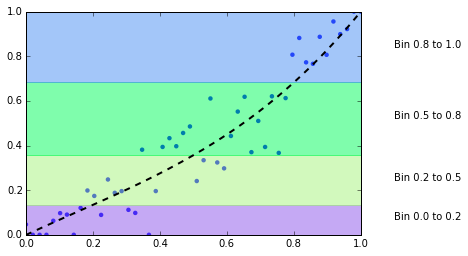

In [5]:
# Set the upper bin parameters in p_{features,z=0.3} we want to fit
vbins = (0.2,0.5,0.8,1.0)

poly = calculate_hbins(vbins)
plot_hbins(poly)

print 'Values of p_features to use:'
print poly(vbins)